In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
import keras
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf
# from tensorflow.keras.datasets.celeb_a import load_data
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-11-02 18:47:52.710038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 18:47:52.895107: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 18:47:53.561330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-02 18:47:53.561394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [ ]:
# !ls data20/data20
# !ls ./data/img_align_celeba/img_align_celeba | head -20 | xargs -I{} cp "./data/img_align_celeba/img_align_celeba/{}" ./data20/data20/

In [14]:
batch_size=128
img_height, img_width = [218, 178]
celeba_path="/home/pancrackhead/Desktop/celeb_googlenet/data/"
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    celeba_path,
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=False,
    seed=123,
    validation_split=0.1,
    subset="training",
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    celeba_path,
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=False,
    seed=123,
    validation_split=0.1,
    subset="validation",
)



Found 202599 files belonging to 1 classes.
Using 182340 files for training.
Found 202599 files belonging to 1 classes.
Using 20259 files for validation.


In [19]:
y = pd.read_csv("./data/list_landmarks_align_celeba.csv").values
y_test = y[len(y)-20259:, 1:]
y_train = y[:len(y)-20259, 1:]


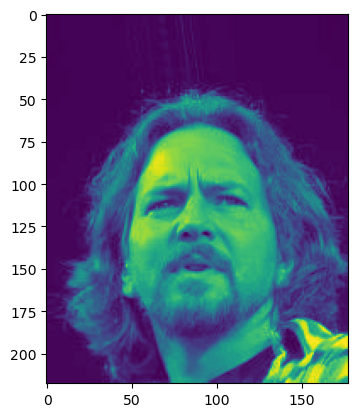

In [7]:
plt.imshow((x_test[0][0][1][:,:,1]))
plt.show()


In [ ]:
# class CelebA():
#   '''Wraps the celebA dataset, allowing an easy way to:
#        - Select the features of interest,
#        - Split the dataset into 'training', 'test' or 'validation' partition.
#   '''
#   def __init__(self, main_folder='/home/pancrackhead/Desktop/celeb_googlenet/data', selected_features=None, drop_features=[]):
#     self.main_folder = main_folder
#     self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
#     self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
#     self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
#     self.landmarks_path  = os.path.join(main_folder, 'list_landmarks_align_celeba.csv')
 
#     self.selected_features = selected_features
#     self.features_name = []
#     self.__prepare(drop_features)

#   def __prepare(self, drop_features):
#     '''do some preprocessing before using the data: e.g. feature selection'''
#     # attributes:
#     if self.selected_features is None:
#       self.attributes = pd.read_csv(self.attributes_path)
#       self.landmarks = pd.read_csv(self.landmarks_path)
#       self.num_features = 40
#     else:
#       self.num_features = len(self.selected_features)
#       self.selected_features = self.selected_features.copy()
#       self.selected_features.append('image_id')
#       self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]
#       self.landmarks = pd.read_csv(self.landmarks_path)[self.selected_features]

#     # remove unwanted features:
#     for feature in drop_features:
#       if feature in self.attributes:
#         self.attributes = self.attributes.drop(feature, axis=1)
#         self.num_features -= 1
      
#     self.attributes.set_index('image_id', inplace=True)
#     self.attributes.replace(to_replace=-1, value=0, inplace=True)
#     self.attributes['image_id'] = list(self.attributes.index)
#     self.landmarks.set_index('image_id', inplace=True)
#     self.landmarks.replace(to_replace=-1, value=0, inplace=True)
#     self.landmarks['image_id'] = list(self.landmarks.index)
  
#     self.features_name = list(self.attributes.columns)[:-1]
  
#     # load ideal partitioning:
#     self.partition = pd.read_csv(self.partition_path)
#     self.partition.set_index('image_id', inplace=True)
  
#   def split(self, name='training', drop_zero=False):
#     '''Returns the ['training', 'validation', 'test'] split of the dataset'''
#     # select partition split:
#     if name is 'training':
#       to_drop = self.partition.where(lambda x: x != 0).dropna()
#     elif name is 'validation':
#       to_drop = self.partition.where(lambda x: x != 1).dropna()
#     elif name is 'test':  # test
#       to_drop = self.partition.where(lambda x: x != 2).dropna()
#     else:
#       raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

#     partition = self.partition.drop(index=to_drop.index)
      
#     # join attributes with selected partition:
#     joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

#     if drop_zero is True:
#       # select rows with all zeros values
#       return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
#     elif 0 <= drop_zero <= 1:
#       zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
#       zero = zero.sample(frac=drop_zero)
#       return joint.drop(index=zero.index)

#     return joint

<>:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_29625/3558366512.py:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'training':
/tmp/ipykernel_29625/3558366512.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif name is 'validation':
/tmp/ipykernel_29625/3558366512.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif name is 'test':  # test


In [ ]:
# load the dataset with 37 out of 40 features:
# celeba = CelebA(drop_features=[
#     'Attractive',
#     'Pale_Skin',
#     'Blurry',
# ])

# celeba.landmarks.sample(5)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,image_id
image_id,,,,,,,,,,,
046154.jpg,70,110,107,112,91,130,74,153,104,153,046154.jpg
050586.jpg,71,113,108,109,76,129,72,153,101,152,050586.jpg
023641.jpg,67,114,111,111,79,123,67,150,108,149,023641.jpg
165868.jpg,87,104,91,103,83,143,86,168,90,167,165868.jpg
023607.jpg,68,113,109,111,81,139,68,151,108,151,023607.jpg


In [28]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [29]:
input_layer = Input(shape=(218, 178, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [30]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

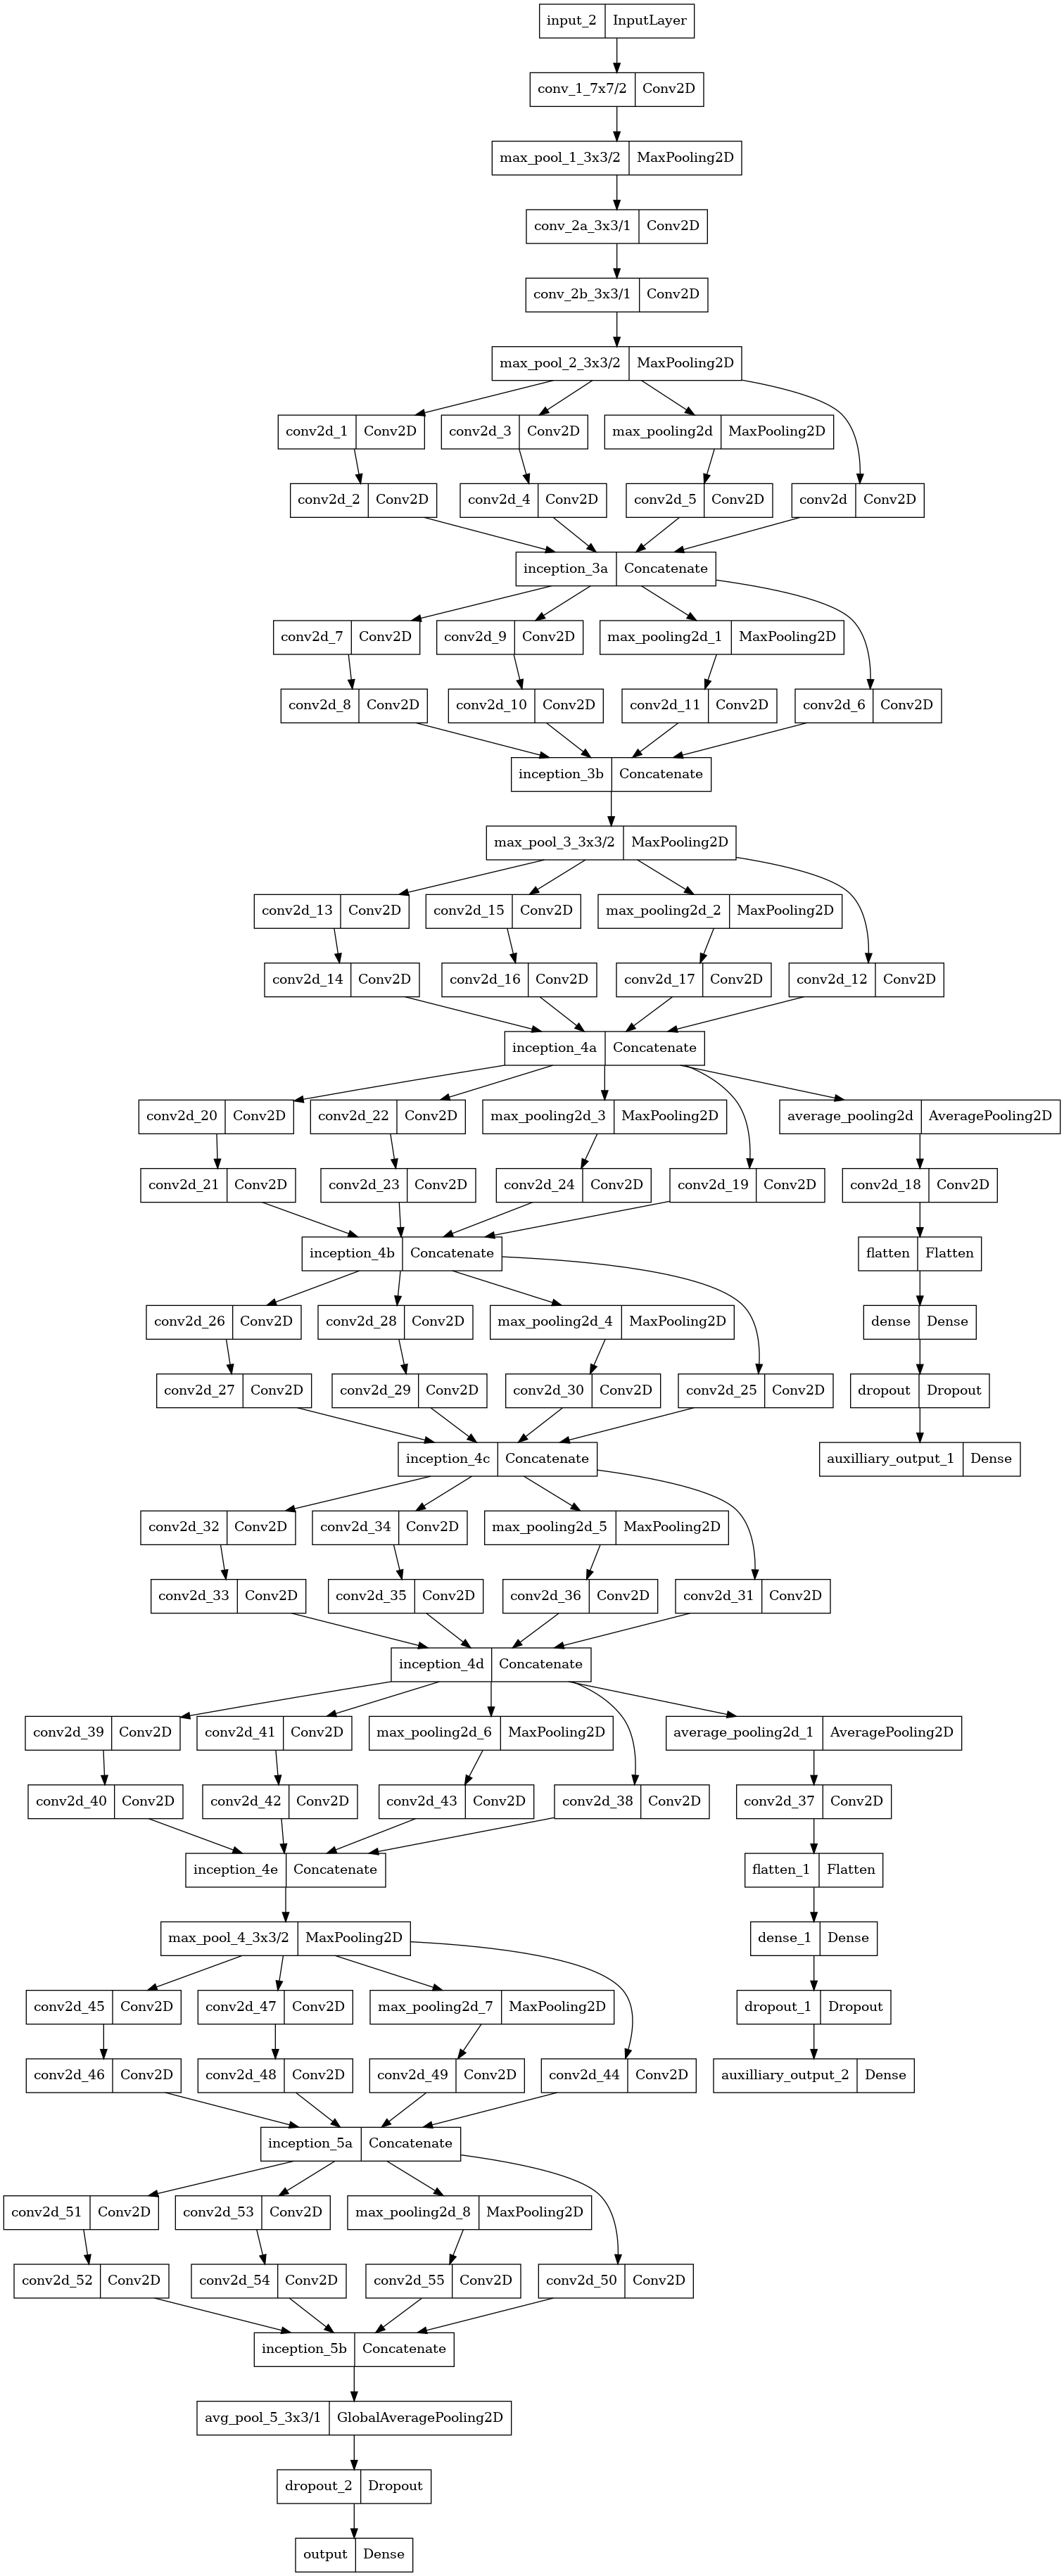

In [31]:
tf.keras.utils.plot_model(model)

In [32]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 109, 89, 64)  9472        ['input_2[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 55, 45, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                                
                                                                                       

In [33]:
epochs = 5

initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])


In [41]:
history = model.fit(ds_train,  validation_data=(ds_validation, [y_test, y_test, y_test]), epochs=epochs, batch_size=128, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/5


TypeError: 'NoneType' object is not callable